In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [2]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/DIG Historical Data 1_6.csv')

In [3]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 6s 121ms/step - loss: 0.0131 - val_loss: 6.6588e-04
Epoch 2/100
21/21 [==============================] - 2s 89ms/step - loss: 0.0012 - val_loss: 2.5299e-04
Epoch 3/100
21/21 [==============================] - 2s 85ms/step - loss: 5.9914e-04 - val_loss: 2.0579e-04
Epoch 4/100
21/21 [==============================] - 2s 80ms/step - loss: 5.3454e-04 - val_loss: 1.8447e-04
Epoch 5/100
21/21 [==============================] - 2s 85ms/step - loss: 4.8743e-04 - val_loss: 1.9866e-04
Epoch 6/100
21/21 [==============================] - 2s 83ms/step - loss: 4.4043e-04 - val_loss: 1.7454e-04
Epoch 7/100
21/21 [==============================] - 1s 66ms/step - loss: 4.2261e-04 - val_loss: 1.6586e-04
Epoch 8/100
21/21 [==============================] - 1s 54ms/step - loss: 4.1063e-04 - val_loss: 1.5994e-04
Epoch 9/100
21/21 [==============================] - 1s 61ms/step - loss: 3.8323e-04 - val_loss: 1.6229e-04
Epoch 10/100
21/21 [===============

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

2/2 [==============================] - 0s 16ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 29483.15784564012


In [14]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))*100
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing MAPE: 99.9991466638062
Testing MAE: 29403.98920658133


In [15]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.23016126453876495], [0.22976061701774597], [0.22935010492801666], [0.22894269227981567], [0.2285436987876892], [0.22815434634685516], [0.2277744859457016], [0.22740352153778076], [0.22704100608825684], [0.22668646275997162], [0.22633931040763855], [0.22599923610687256], [0.22566580772399902], [0.22533881664276123], [0.2250179499387741], [0.22470299899578094], [0.2243938148021698], [0.22409021854400635], [0.22379198670387268], [0.22349901497364044], [0.2232111692428589], [0.22292838990688324], [0.2226504683494568], [0.22237731516361237], [0.2221088856458664], [0.22184500098228455], [0.22158564627170563], [0.2213307023048401], [0.2210800051689148], [0.22083361446857452], [0.22059133648872375], [0.22035318613052368], [0.22011905908584595], [0.21988877654075623], [0.21966241300106049], [0.21943989396095276], [0.21922102570533752], [0.21900580823421478], [0.21879422664642334], [0.21858614683151245], [0.21838155388832092], [0.2181803435087204], [0.2179824858903885], [0.21778787672519684]

In [16]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[27675.69962195],
       [27638.99834585],
       [27601.39342692],
       [27564.07243202],
       [27527.52267308],
       [27491.85608167],
       [27457.05900761],
       [27423.07685012],
       [27389.86865861],
       [27357.39075248],
       [27325.58989596],
       [27294.43742365],
       [27263.89374998],
       [27233.93976468],
       [27204.54680235],
       [27175.69575271],
       [27147.37296557],
       [27119.5620607 ],
       [27092.24256281],
       [27065.40491676],
       [27039.03683738],
       [27013.13286458],
       [26987.67388811],
       [26962.65171783],
       [26938.0622587 ],
       [26913.88913048],
       [26890.13096815],
       [26866.77685156],
       [26843.8117655 ],
       [26821.24117003],
       [26799.04731992],
       [26777.23158017],
       [26755.78439565],
       [26734.68938614],
       [26713.95337672],
       [26693.5695423 ],
       [26673.52013763],
       [26653.80516271],
       [26634.42325252],
       [26615.36212189],


In [17]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = scaler.inverse_transform(test_data[:101])
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [18]:
print(y_pred_with_test_data.shape)
test_data.shape

(160,)


(160, 1)

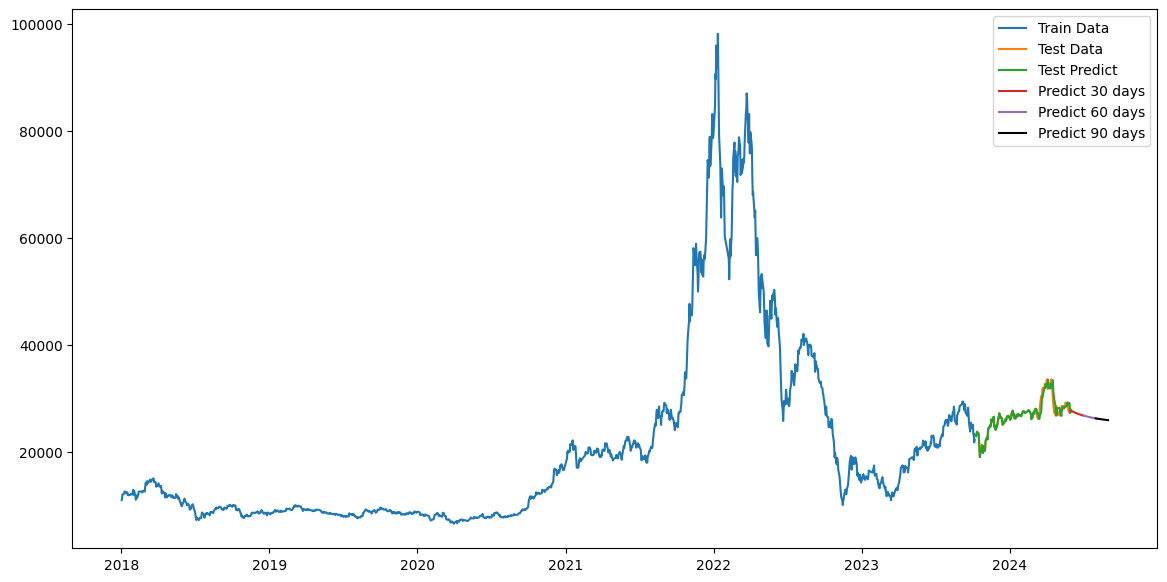

In [19]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:train_size + len(y_pred_with_test_data)], y_pred_with_test_data, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=31)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=31)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[29:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[59:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()